In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Lars
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

from xgboost import XGBClassifier, XGBRFClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

import optuna

In [3]:
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/data_lab2.csv')

In [ ]:
data.isna().sum()[data.isna().sum() > 0]

,0


In [5]:
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [6]:
data['Bankrupt?'].value_counts(normalize=True)

,proportion
Bankrupt?,
0,0.967737
1,0.032263


<Axes: xlabel='Bankrupt?', ylabel='Count'>

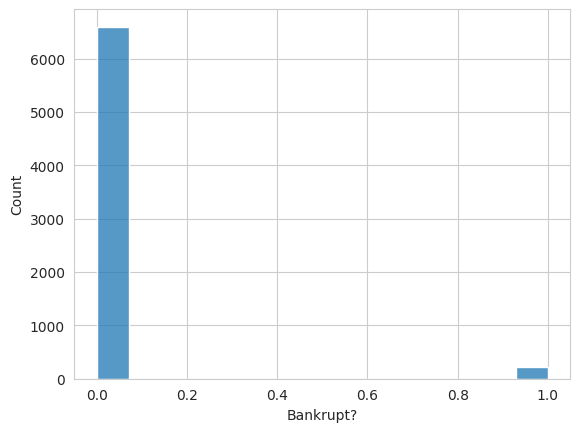

In [7]:
sns.histplot(data['Bankrupt?'])

In [8]:
data[' Net Income Flag'].value_counts()

,count
Net Income Flag,
1,6819


In [10]:
data[' Liability-Assets Flag'].value_counts()

,count
Liability-Assets Flag,
0,6811
1,8


## Предобработка

In [ ]:
def drop_col(X:pd.DataFrame, cols):
  X = X.copy()
  X = X.drop(cols, axis=1)
  X = X.drop_duplicates()

  return X

In [11]:
def make_feature(X:pd.DataFrame):
  X['A_feature'] = X[' Net worth/Assets'] / (X[' Debt ratio %'] / 100)
  X['B_feature'] = X[' Net worth/Assets'] / (X[' Current Liability to Assets'] + X[' Debt ratio %'] / 100)
  X['C_feature'] = X[' Working Capital to Total Assets'] / X[' Current Liability to Assets']
  X = np.log1p(1/(X+1e-6))
  return X

In [13]:
drop_cols = FunctionTransformer(drop_col,
                                kw_args = {'cols' : [' Net Income Flag', ' Liability-Assets Flag', ' Equity to Long-term Liability', ' Operating Profit Rate']}
                                )

make_cols = FunctionTransformer(make_feature)

preprocessing = Pipeline(steps=[
    ('make_feature', make_cols),
    ('drop', drop_cols),
    #('poly_features', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', RobustScaler())
])

preprocessing.set_output(transform='pandas')

Pipeline(steps=[('make_feature',
                 FunctionTransformer(func=<function make_feature at 0x7d82bdd3cea0>)),
                ('drop',
                 FunctionTransformer(func=<function drop_col at 0x7d82bdd3cb80>,
                                     kw_args={'cols': [' Net Income Flag',
                                                       ' Liability-Assets Flag',
                                                       ' Equity to Long-term '
                                                       'Liability',
                                                       ' Operating Profit '
                                                       'Rate']})),
                ('scaler', RobustScaler())])

In [14]:
y = data['Bankrupt?']
X = data.drop('Bankrupt?', axis=1)

X_train, X_tmp, y_train, y_tmp = train_test_split(X,y, test_size=.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5, random_state=42, stratify=y_tmp)

In [15]:
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_valid = preprocessing.transform(X_valid)
X_test = preprocessing.transform(X_test)

## Модели

In [16]:
def plot_roc_cure_f1(y_test, y_pred, y_pred_proba):
  plt.figure(figsize=(7,5))


  fpr, tpr, th = roc_curve(y_test, y_pred_proba)
  plt.plot(fpr, tpr)

  plt.plot([0, 1], [0, 1], 'k--')
  plt.legend()
  plt.grid()
  plt.show()

  print(classification_report(y_test, y_pred))

In [18]:
def plot_roc_curves(y_test, y_pred):
  plt.figure(figsize=(7,5))

  for y_pred_i in y_pred:
    fpr, tpr, th = roc_curve(y_test, y_pred_i[0])
    plt.plot(fpr, tpr, label=f'{y_pred_i[1]}')

  plt.plot([0, 1], [0, 1], 'k--')
  plt.legend()
  plt.grid()
  plt.show()

In [55]:
def create_report_series(models, X_train, X_test, y_train, y_test, pt=False):
  model_f1_auc = []
  model_roc_auc = []
  model_name = []
  model_pred = []

  if pt==0:
    for model in models:
      model.fit(X_train, y_train)

  for model in models:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    model_f1_auc.append(f1_score(y_test, y_pred))
    model_roc_auc.append(roc_auc_score(y_test, y_pred))
    model_name.append(model.__class__.__name__)
    model_pred.append(y_pred_proba)

  f1 = pd.Series(model_f1_auc, index=model_name)
  rc = pd.Series(model_roc_auc, index=model_name)
  report = pd.DataFrame({'F1-score' : f1,
                         'ROC AUC' : rc})
  print(report)
  plot_roc_curves(y_test, zip(model_pred, model_name))

In [20]:
def cosine_lr(iter, max_iter=1000):
  min_lr = 0.0005
  max_lr = 0.1
  lr = min_lr + .5 * (max_lr - min_lr) * (1 + np.cos((iter / max_iter) * np.pi))

  return lr

schedule = xgb.callback.LearningRateScheduler(cosine_lr)

scale = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
scale_val = scale.max()/scale.min()

In [23]:
def objective(trial):

  '''
  model = XGBRFClassifier(n_estimators=trial.suggest_int('xgb_num_tree', 100, 1000),
                          learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                          #callbacks=[schedule],
                          max_depth = trial.suggest_int('xgb_max_depth', 3, 15),
                          scale_pos_weight=scale_val,
                          random_state=42,
                          )
  '''
  model = XGBClassifier(n_estimators=trial.suggest_int('n_estimators', 100, 1000),
                        #learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                        callbacks=[schedule],
                        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10, log=True),
                        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10, log=True),
                        max_depth = trial.suggest_int('max_depth', 3, 15),
                        tree_method = trial.suggest_categorical('tree_method', ['hist', 'exact', 'approx']),
                        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
                        scale_pos_weight=scale_val,
                        random_state=42,
                        )
  '''
  model = LGBMClassifier(n_estimators=trial.suggest_int('n_estimators', 100, 2000),
                         learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                         reg_lambda = trial.suggest_float('reg_lambda', 0.01, 100, log=True),
                         reg_alpha = trial.suggest_float('reg_alpha', 0.01, 100, log=True),
                         subsample = trial.suggest_float('subsample', 0.6, 0.9),
                         max_depth = trial.suggest_int('max_depth', 3, 15),
                         class_weight = 'balanced',
                         n_jobs=-1,
                         random_state=42,
                         )
  '''

  '''
  model = SVC(kernel=trial.suggest_categorical('kernel', ['poly', 'linear', 'rbf']),
              C = trial.suggest_float('C', 0.001, 20, log=True),
              max_iter = trial.suggest_int('max_iter', 500, 5000),
              class_weight='balanced',
              probability=True,
              random_state=42,
              )

  '''

  '''
  model = LogisticRegression(max_iter = trial.suggest_int('max_iter', 100, 5000),
                             l1_ratio = trial.suggest_float('l1_ratio', 0.001, 1, log=True),
                             C = trial.suggest_float('C', 0.001, 10, log=True),
                             solver='saga',
                             penalty='elasticnet',
                             class_weight='balanced',
                             random_state=41)
  '''

  score = cross_val_score(model,
                          X_train, y_train,
                          scoring='f1',
                          n_jobs=1,
                          cv=5,
                          )

  f1_score = score.mean()

  return f1_score

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-11-20 17:29:28,883] A new study created in memory with name: no-name-7903007d-e945-403d-b89c-b475ee4cb20c
[I 2025-11-20 17:30:31,403] Trial 0 finished with value: 0.4060561258978444 and parameters: {'n_estimators': 865, 'reg_lambda': 1.0141660177436196, 'reg_alpha': 4.431140854645931, 'max_depth': 6, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.4060561258978444.
[I 2025-11-20 17:32:59,676] Trial 1 finished with value: 0.3423228310750757 and parameters: {'n_estimators': 886, 'reg_lambda': 0.3749634526361096, 'reg_alpha': 0.08429340515495191, 'max_depth': 11, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4060561258978444.
[I 2025-11-20 17:33:46,080] Trial 2 finished with value: 0.3553714997704768 and parameters: {'n_estimators': 302, 'reg_lambda': 0.12802118955562652, 'reg_alpha': 0.2611496560804018, 'max_depth': 8, 'tree_method': 'exact', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4060561

In [25]:
print("Количество завершенных испытаний: ", len(study.trials))
trial = study.best_trial

print("Значение метрики: ", trial.value)
print("Лучшие гиперпараметры: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Количество завершенных испытаний:  10
Значение метрики:  0.4193285182925629
Лучшие гиперпараметры: 
    n_estimators: 962
    reg_lambda: 0.05161886200865232
    reg_alpha: 8.430604789195591
    max_depth: 8
    tree_method: exact
    grow_policy: lossguide


In [26]:
cat_params = {'iterations': 957,
            'learning_rate': 0.012125295258816003,
            'depth': 8,
            'l2_leaf_reg': 0.0015393511598471943,
            'eval_metric' : 'F1',
            'loss_function' : 'Logloss',
            'scale_pos_weight' : scale_val,
            'verbose':False,
            'random_seed' : 42,
            }
model_cat = CatBoostClassifier(**cat_params)

In [35]:
lgbm_params = {'n_estimators': 1374,
              'learning_rate': 0.023373054356969142,
              'reg_lambda': 0.13427618195760568,
              'reg_alpha': 1.1050589496505898,
              'subsample': 0.7375799597412454,
              'max_depth': 6,
              'class_weight' : 'balanced',
              'n_jobs':-1,
              'random_state':42,
              'verbose':-1,
               }

model_lgbm = LGBMClassifier(**lgbm_params)

In [28]:
xgbrf_params = {'xgb_num_tree': 732,
                'learning_rate': 0.021067879181371492,
                'xgb_max_depth': 6,
                'scale_pos_weight':scale_val,
                'random_state':42,
                }
model_xgbrf = XGBRFClassifier(**xgbrf_params)

In [29]:
xgb_params = {'n_estimators': 962,
              'reg_lambda': 0.05161886200865232,
              'reg_alpha': 8.430604789195591,
              'max_depth': 8,
              'tree_method': 'exact',
              'grow_policy': 'lossguide',
              'callbacks' : [schedule],
              'scale_pos_weight' : scale_val,
              'random_state':42,
              }
model_xgb = XGBClassifier(**xgb_params)

In [30]:
models_1 = [
    ('rf', model_xgbrf),
    ('xgb', model_xgb),
    ('lgbm', model_lgbm),
#    ('cat', model_cat),
]

svc_params = {'kernel': 'poly',
              'C': 0.12674431494668786,
              'max_iter': 3086,
              'class_weight' : 'balanced',
              'probability' : True,
              'random_state' : 42}

model_lr = LogisticRegression(max_iter=3689,
                              l1_ratio=0.4979921297578755,
                              C=0.2747537336277005,
                              solver='saga',
                              penalty='elasticnet',
                              class_weight='balanced',
                              random_state=42)
model_svc = SVC(**svc_params)

model_2 = [
    ('logreg', model_lr),
    ('svc', model_svc)
]


stack = StackingClassifier(models_1,
                           cv = 5,
                           n_jobs = -1,
                           final_estimator=model_lr,
                           )

In [31]:
model_cat.fit(X=X_train, y=y_train,
              early_stopping_rounds=20)

In [36]:
model_lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.023373054356969142,
               max_depth=6, n_estimators=1374, n_jobs=-1, random_state=42,
               reg_alpha=1.1050589496505898, reg_lambda=0.13427618195760568,
               subsample=0.7375799597412454, verbose=-1)

In [33]:
model_xgbrf.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None,
                learning_rate=0.021067879181371492, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [34]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None,
              callbacks=[<xgboost.callback.LearningRateScheduler object at 0x7d82c11fff20>],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=962,
              n_jobs=None, num_parallel_tree=None, ...)

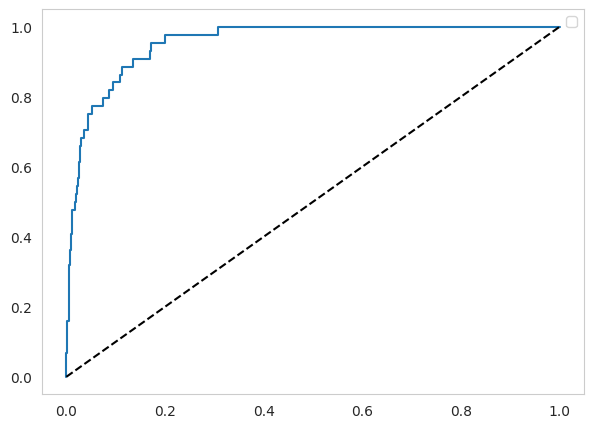

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.54      0.48      0.51        44

    accuracy                           0.97      1364
   macro avg       0.76      0.73      0.75      1364
weighted avg       0.97      0.97      0.97      1364



In [37]:
y_pred_lgbm = model_lgbm.predict(X_valid)
y_pred_proba_lgbm = model_lgbm.predict_proba(X_valid)[:, 1]
plot_roc_cure_f1(y_valid, y_pred_lgbm, y_pred_proba_lgbm)

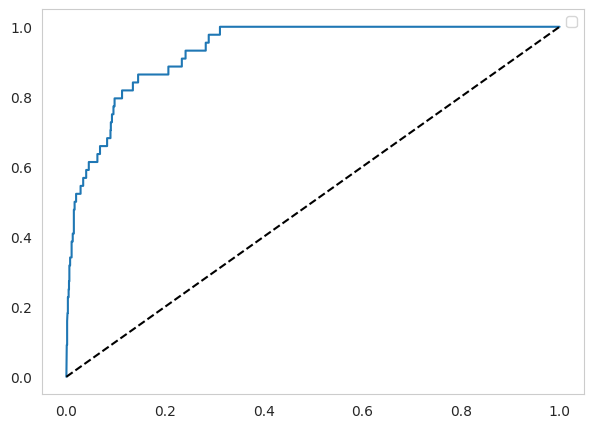

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.28      0.61      0.38        44

    accuracy                           0.94      1364
   macro avg       0.63      0.78      0.67      1364
weighted avg       0.96      0.94      0.95      1364



In [38]:
y_pred_rf = model_xgbrf.predict(X_valid)
y_pred_proba_rf = model_xgbrf.predict_proba(X_valid)[:, 1]
plot_roc_cure_f1(y_valid, y_pred_rf, y_pred_proba_rf)

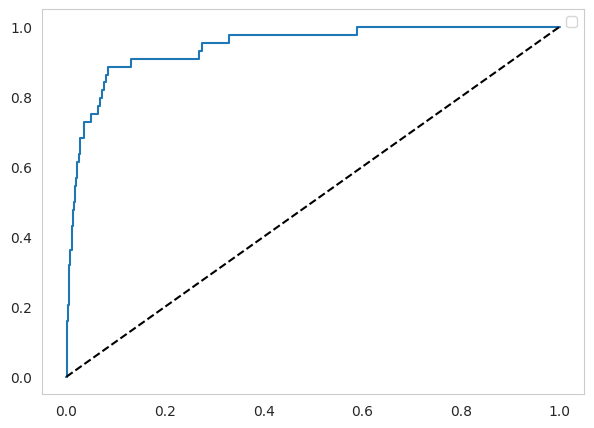

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.49      0.57      0.53        44

    accuracy                           0.97      1364
   macro avg       0.74      0.77      0.75      1364
weighted avg       0.97      0.97      0.97      1364



In [39]:
y_pred_xgb = model_xgb.predict(X_valid)
y_pred_proba_xgb = model_xgb.predict_proba(X_valid)[:, 1]
plot_roc_cure_f1(y_valid, y_pred_xgb, y_pred_proba_xgb)

In [40]:
stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                XGBRFClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bytree=None,
                                                device=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None,
                                                feature_weights=None,
                                                gamma=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                lear...
                                               learning_rate=0.023373054356969142,
                                               max_depth=6, n_estimators=1374,
                                               n_jobs=-1, random_state=42,
                                               reg_alpha=1.1050589496505898,
                                               reg_lambda=0.13427618195760568,
                                               subsample=0.7375799597412454))],
                   final_estimator=LogisticRegression(C=0.2747537336277005,
                                                      class_weight='balanced',
                                                      l1_ratio=0.4979921297578755,
                                                      max_iter=3689,
                                                      penalty='elasticnet',
                                                      random_state=42,
                                                      solver='saga'),
                   n_jobs=-1)

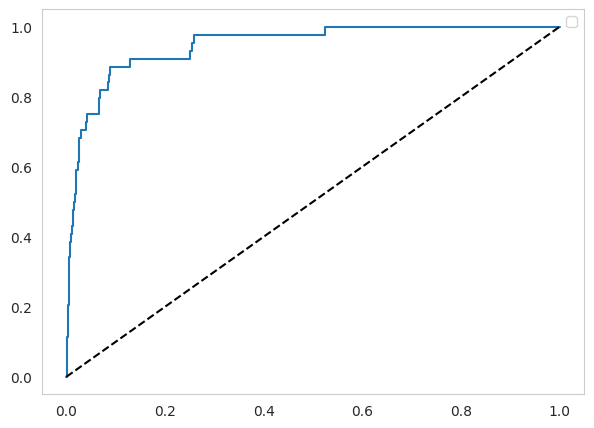

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.33      0.75      0.46        44

    accuracy                           0.94      1364
   macro avg       0.66      0.85      0.71      1364
weighted avg       0.97      0.94      0.95      1364



In [41]:
y_pred_stack = stack.predict(X_valid)
y_pred_proba_stack = stack.predict_proba(X_valid)[:, 1]
plot_roc_cure_f1(y_valid, y_pred_stack, y_pred_proba_stack)

## Test

In [42]:
fi_valid = pd.Series(model_xgb.feature_importances_, X_valid.columns.to_list())
fi_list_valid = list(fi_valid[fi_valid > 0].index)

In [46]:
X_train = X_train[fi_list_valid]
X_valid = X_valid[fi_list_valid]
X_test = X_test[fi_list_valid]

X_train_val = np.vstack([X_train, X_valid])
y_train_val = np.concatenate([y_train, y_valid])


In [48]:
model_xgb.fit(X_train_val, y_train_val)
model_lgbm.fit(X_train_val, y_train_val)
model_xgbrf.fit(X_train_val, y_train_val)
model_cat.fit(X=X_train_val, y=y_train_val)

In [49]:
stack.fit(X_train_val, y_train_val)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                XGBRFClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bytree=None,
                                                device=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None,
                                                feature_weights=None,
                                                gamma=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                lear...
                                               learning_rate=0.023373054356969142,
                                               max_depth=6, n_estimators=1374,
                                               n_jobs=-1, random_state=42,
                                               reg_alpha=1.1050589496505898,
                                               reg_lambda=0.13427618195760568,
                                               subsample=0.7375799597412454))],
                   final_estimator=LogisticRegression(C=0.2747537336277005,
                                                      class_weight='balanced',
                                                      l1_ratio=0.4979921297578755,
                                                      max_iter=3689,
                                                      penalty='elasticnet',
                                                      random_state=42,
                                                      solver='saga'),
                   n_jobs=-1)

                    F1-score   ROC AUC
XGBClassifier       0.475248  0.760227
XGBRFClassifier     0.449275  0.828409
CatBoostClassifier  0.447761  0.667424
StackingClassifier  0.428571  0.815909
LGBMClassifier      0.494118  0.731061


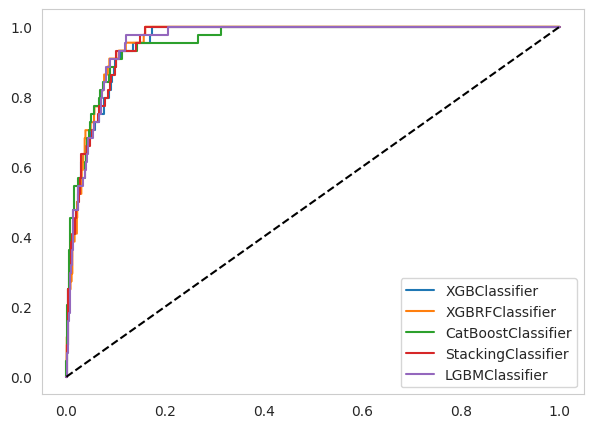

In [56]:
create_report_series([model_xgb, model_xgbrf, model_cat, stack, model_lgbm],
                     X_train_val, X_test,
                     y_train_val, y_test,
                     pt=1
                     )

In [58]:
def plot_fi(scores):
  plt.figure(figsize=(50,50))
  scores = scores.sort_values()
  width = np.arange(len(scores))
  ticks = list(scores.index)

  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.show()

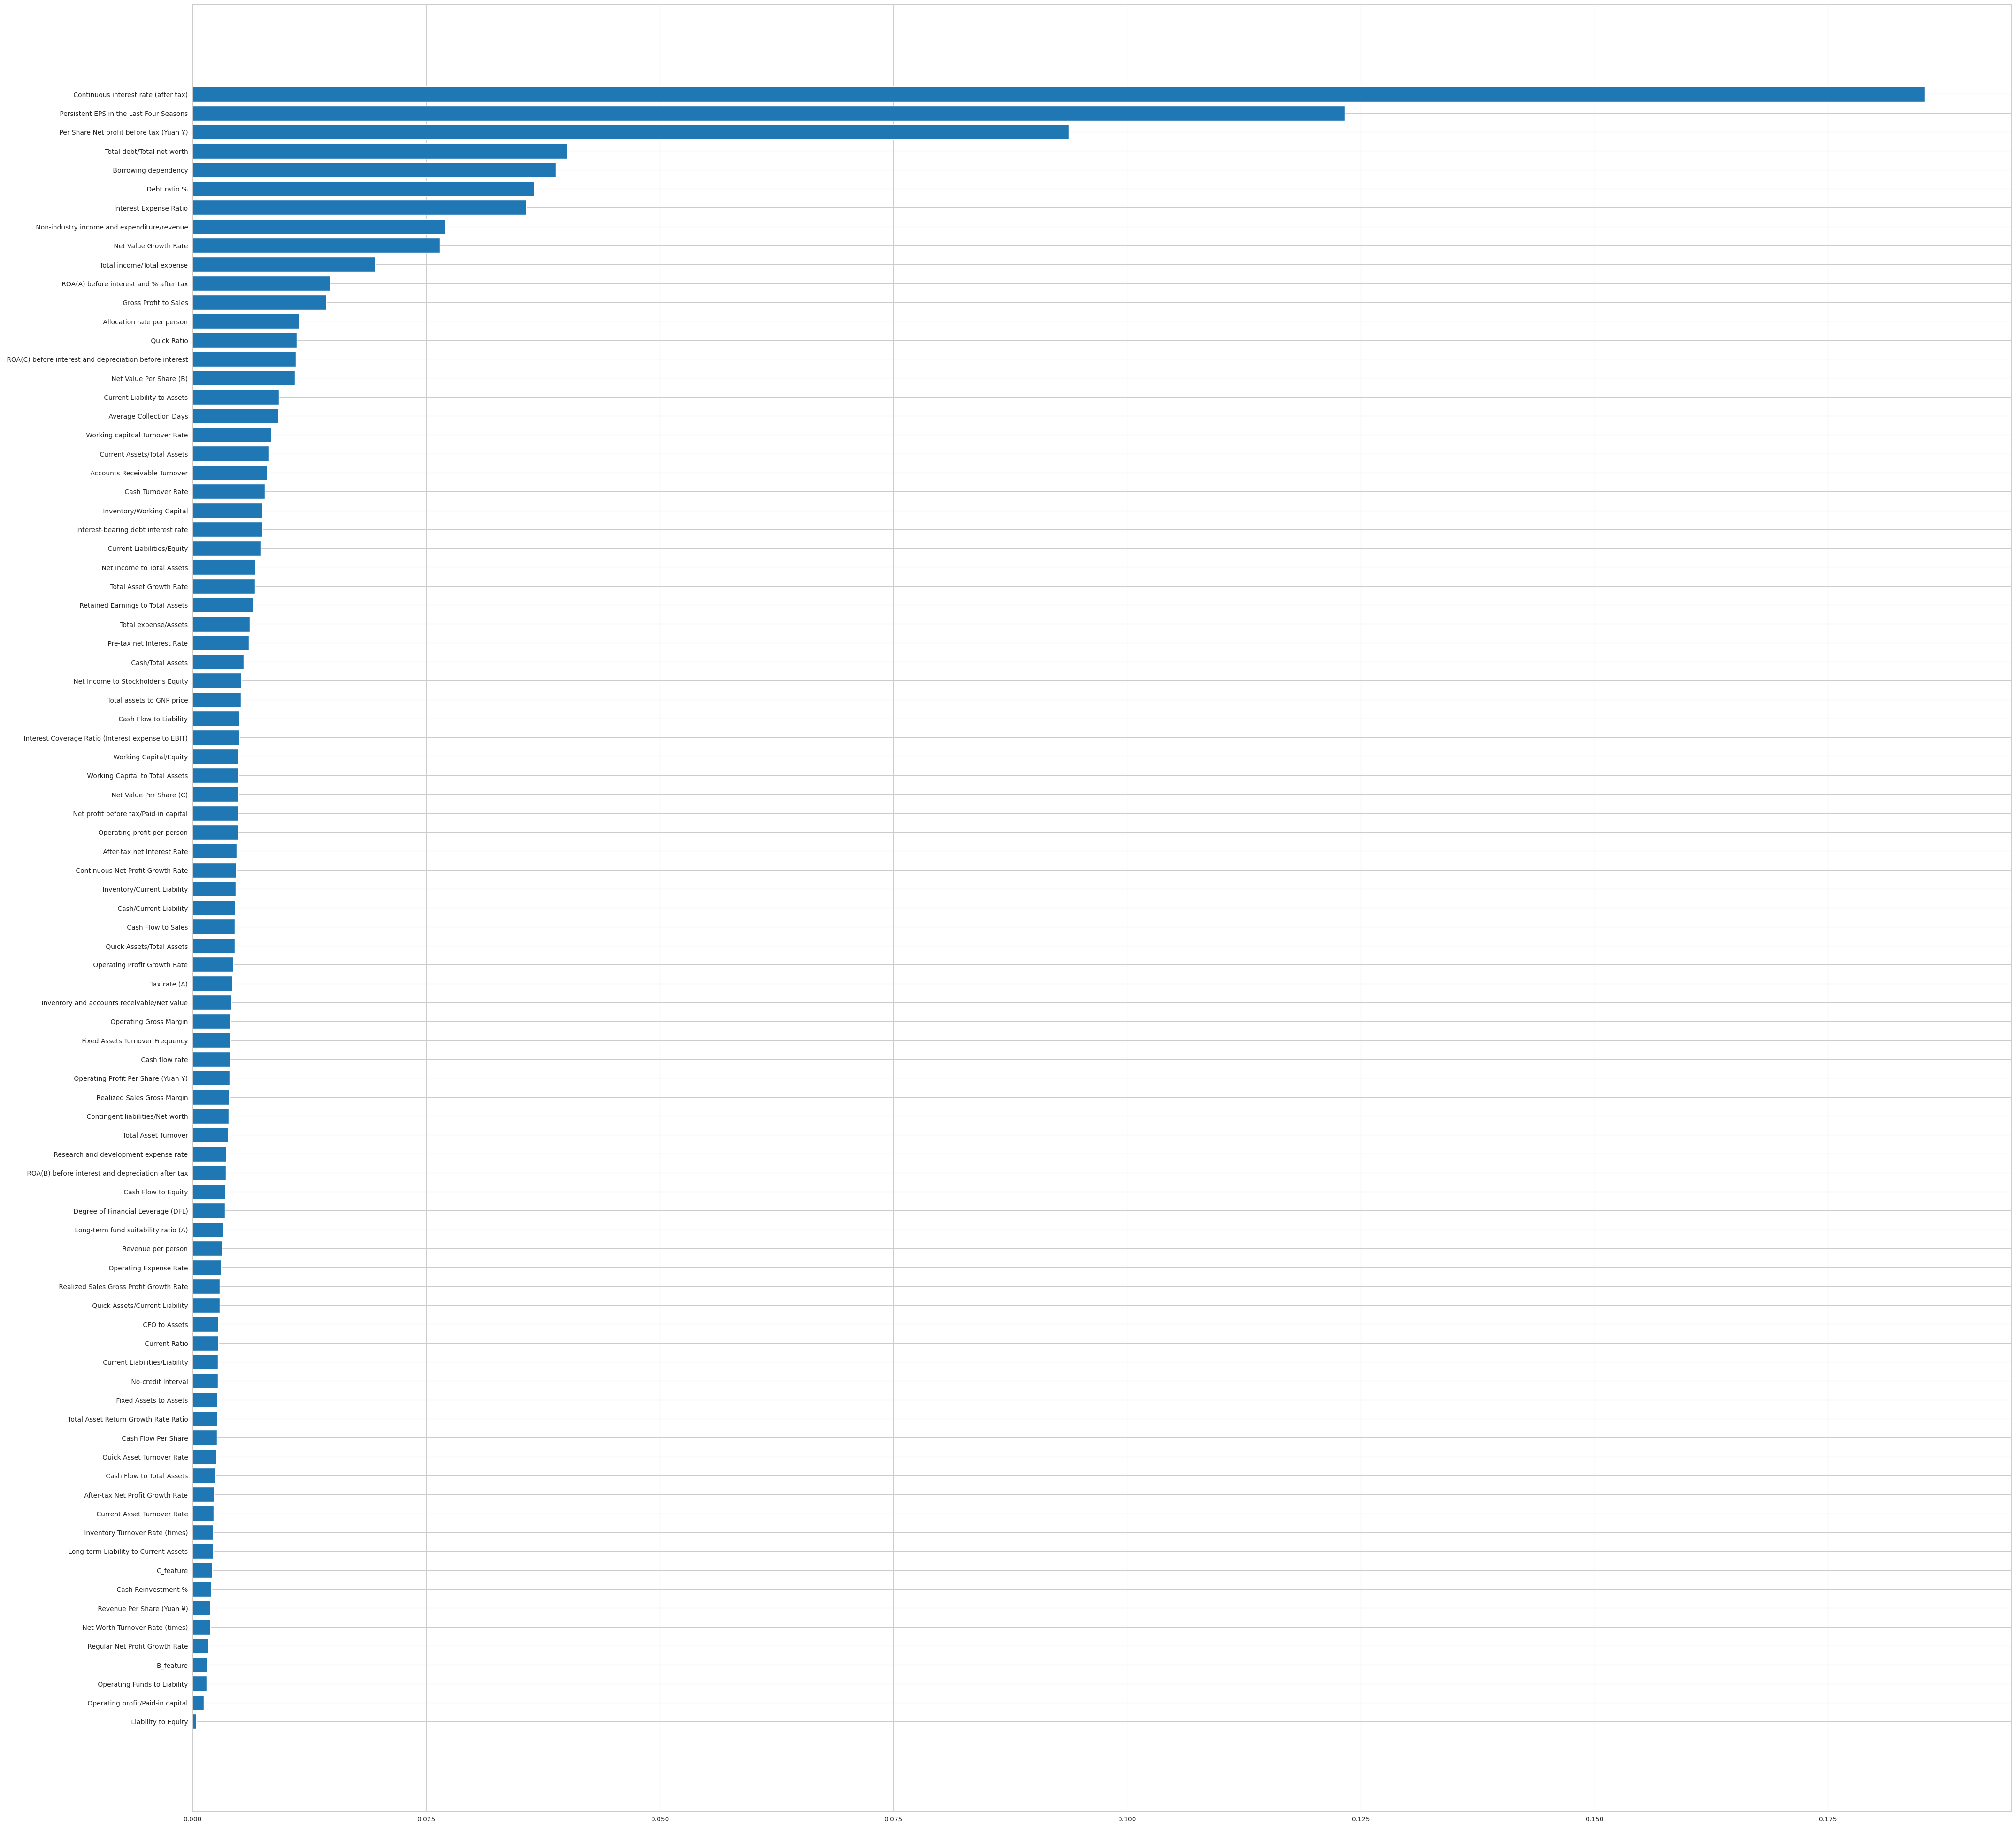

In [60]:
fi = pd.Series(model_xgb.feature_importances_, X_test.columns.to_list())
plot_fi(fi)